In [2]:
from tensorflow.keras.datasets import cifar100
import numpy as np

In [3]:
(x_train, _), (x_test, _) = cifar100.load_data()

169009152/169001437 [==============================] - 214s 1us/step


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [7]:
input_img = Input(shape=(32, 32, 1)) # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [8]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [9]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [10]:
def rgb2gray1(rgb):
 return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

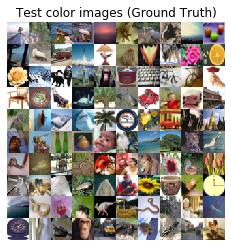

In [13]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

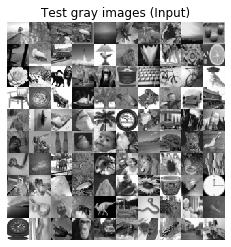

In [12]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

x_train_gray = rgb2gray1(x_train)
x_test_gray = rgb2gray1(x_test)
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
#plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [14]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [15]:
# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [16]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [17]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
 x = Conv2D(filters=filters,
 kernel_size=kernel_size,
 strides=2,
 activation='relu',
 padding='same')(x)

In [18]:
shape = K.int_shape(x)

In [21]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [22]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [23]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

In [24]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [25]:
for filters in layer_filters[::-1]:
 x = Conv2DTranspose(filters=filters,
 kernel_size=kernel_size,
 strides=2,
 activation='relu',
 padding='same')(x)
outputs = Conv2DTranspose(filters=channels,
 kernel_size=kernel_size,
 activation='sigmoid',
 padding='same',
 name='decoder_output')(x)

In [26]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

In [27]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [28]:
autoencoder.compile(loss='mse', optimizer='adam')

In [29]:
autoencoder.fit(x_train_gray,
 x_train,
 validation_data=(x_test_gray, x_test),
 epochs=10,
 batch_size=batch_size,
 #callbacks=callbacks
 )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 42s 849us/sample - loss: 0.0186 - val_loss: 0.0144
Epoch 2/10
50000/50000 [==============================] - 36s 715us/sample - loss: 0.0135 - val_loss: 0.0129
Epoch 3/10
50000/50000 [==============================] - 35s 710us/sample - loss: 0.0124 - val_loss: 0.0121
Epoch 4/10
50000/50000 [==============================] - 35s 710us/sample - loss: 0.0118 - val_loss: 0.0123
Epoch 5/10
50000/50000 [==============================] - 35s 709us/sample - loss: 0.0114 - val_loss: 0.0116
Epoch 6/10
50000/50000 [==============================] - 36s 710us/sample - loss: 0.0111 - val_loss: 0.0115
Epoch 7/10
50000/50000 [==============================] - 36s 712us/sample - loss: 0.0107 - val_loss: 0.0113
Epoch 8/10
50000/50000 [==============================] - 35s 709us/sample - loss: 0.0104 - val_loss: 0.0116
Epoch 9/10
50000/50000 [==============================] - 35s 710us/sample - l

In [30]:
x_decoded = autoencoder.predict(x_test_gray)

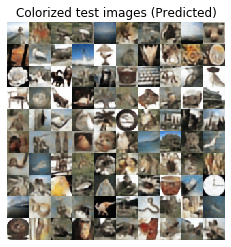

In [31]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

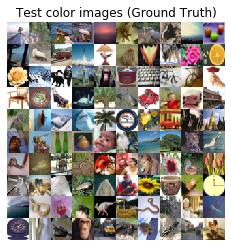

In [32]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()